In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tushare as ts

# pip install statsmodels
from statsmodels.tsa.stattools import adfuller

首先想到利用统计套利，可能会想到两只股票的相关系数是否会让两只股票的走势有一种特定关系。

In [2]:
#我们来看看相关系数高的数据集具体长什么样
#X = np.random.rand(50)
#Y = X + np.random.normal(0, 0.1, 50)
#
#plt.scatter(X,Y)
#plt.xlabel('X Value')
#plt.ylabel('Y Value')
#
#print ('相关系数：' + str(np.corrcoef(X, Y)[0, 1]))

#从图像上看，数据基本都落在一条直线上那么它们之间的相关性就会很高。 
#接下来我们来看看两只股票价格之间相关性高长什么样

#此处时间一定要与回测的时间相对应，因为不同时间可能相关性不一致
start = '2014-01-01'
end   = '2016-11-01'
stock1='601618'
stock2='600026'
a1 = ts.get_hist_data(stock1, start,end)
a1 = a1['close']
a2 = ts.get_hist_data(stock2, start,end)
a2 = a2['close']


In [3]:
#处理缺失值
stock = pd.DataFrame()
stock['a1'] = a1
stock['a2'] = a2
stock = stock.dropna()
a1 = stock['a1']
a2 = stock['a2']


('601618 and 600026 corrcoef : ', 0.9605317671213618)


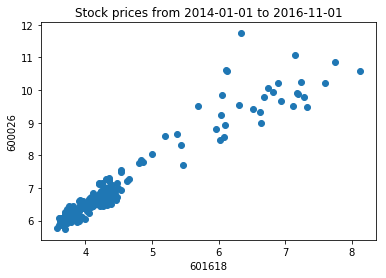

In [4]:
#画出散点图判断相关性
plt.scatter(a1.values,a2.values)
plt.xlabel(stock1)
plt.ylabel(stock2)
plt.title('Stock prices from ' + start + ' to ' + end)
print (stock1+" and "+stock2+" corrcoef : ", np.corrcoef(a1,a2)[0,1])

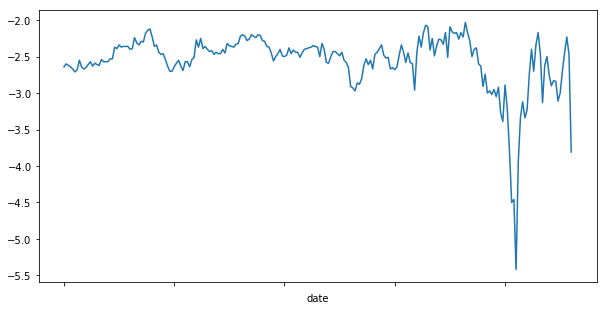

In [5]:
##a3表示他们的价差
a3=a1-a2
a3.plot(figsize=(10,5))
#
#从图中看出，所以相关系数高，两者之间的价差不一定会围绕一个常数波动，
#价差会具有一定的变异性，即价差序列是非平稳的。 我们来检验下价差的平稳性。


同样数据大多都集中在一条直线上
找到相关性高的股票对，我们要来研究它们之间的价差，因为这是我们策略套利的关键

In [6]:
adftest = adfuller(a3) #使用adf单位根检验平稳性
result = pd.Series(adftest[0:4], index=[
    'Test Statistic','p-value','Lags Used','Number of Observations Used'])

for key,value in adftest[4].items():
        result['Critical Value (%s)'%key] = value
        
print(result)


Test Statistic                  -3.802977
p-value                          0.002877
Lags Used                        0.000000
Number of Observations Used    230.000000
Critical Value (5%)             -2.874190
Critical Value (1%)             -3.459106
Critical Value (10%)            -2.573512
dtype: float64


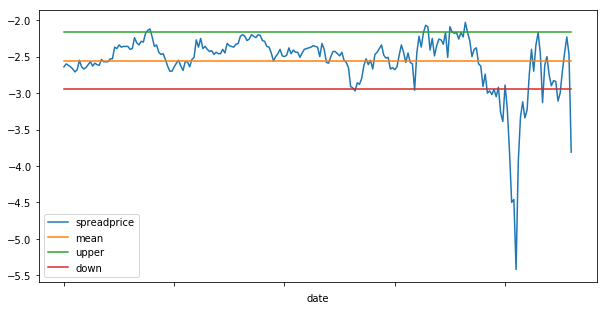

In [7]:
# 上面使用了adf单位根检验，此处检验出来价差非平稳，套利策略的数据基础不好。


# 进一步的我们来看看以均值加减一倍标准差是否包含了大部分的差价区间
mean=np.mean(a3)
std=np.std(a3)
up=mean+std
down=mean-std
time=a3.index
mean_line=pd.Series(mean,index=time)
up_line=pd.Series(up,index=time)
down_line=pd.Series(down,index=time)
set=pd.concat([a3,mean_line,up_line,down_line],axis=1)
set.columns=['spreadprice','mean','upper','down']
set.plot(figsize=(10,5))

In [8]:
#可以看到虽然包含了大部分价差区间，但是开仓次数太少，
#并且在2014年股票的差价都是在上开仓线附近小幅波动，
#会造成频繁开仓使得成本十分高。
#同时观察2015年价差出现极端值，此时如果开仓，价差不收敛，
#如果没做到好的平仓条件此时会造成大量亏损。

print'\n结论：此股票虽然相关性足够，但协整性不足，不可以进行套利\n'
print'简单来说我们无法利用这个不收敛的价差来进行套利'


结论：此股票虽然相关性足够，但协整性不足，不可以进行套利

简单来说我们无法利用这个不收敛的价差来进行套利


In [9]:
##通过差分我们得到的就是一个跟噪声序列长的一样的平稳序列了。 
##那么一般股票序列是非平稳的我们怎么去找协整关系构建平稳的序列呢。
#
#定义函数进行协整性计算
def find_cointegrated_pairs(dataframe):
    # 得到DataFrame长度
    n = dataframe.shape[1]
    # 初始化p值矩阵
    pvalue_matrix = np.ones((n, n))
    # 抽取列的名称
    keys = dataframe.keys()
    # 初始化强协整组
    pairs = []
    # 对于每一个i
    for i in range(n):
        # 对于大于i的j
        for j in range(i+1, n):
            # 获取相应的两只股票的价格Series
            stock1 = dataframe[keys[i]]
            stock2 = dataframe[keys[j]]
            # 分析它们的协整关系
            result = sm.tsa.stattools.coint(stock1, stock2)
            # 取出并记录p值
            pvalue = result[1]
            pvalue_matrix[i, j] = pvalue
            # 如果p值小于0.05
            if pvalue < 0.05:
                # 记录股票对和相应的p值
                pairs.append((keys[i], keys[j], pvalue))
    # 返回结果
    return pvalue_matrix, pairs

[('601988', '601398', 0.004694362052358513), ('601988', '601939', 0.01772845055938455), ('601988', '600036', 0.012759700309140427), ('601939', '600036', 0.04058504623055453), ('601818', '601166', 0.022894450907693945)]


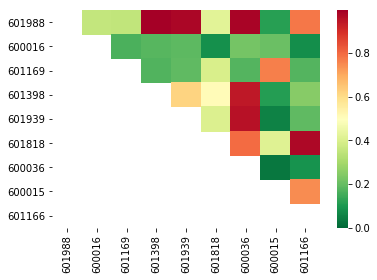

In [10]:
import statsmodels.api as sm
import seaborn as sns

#选出一组股票列表
stock = pd.DataFrame()
list = ['601988','600016','601169','601398','601939','601818','600036','600015','601166']
#list =['601988','600016','601169','601997','600926','601818','600919','600000','601288','601128','600908','601328','601398','600036','601939','600015','601166','601009','601229']
df = ts.get_k_data(list[0])[['date','close']].set_index('date')
df.columns=[list[0]]
for i in list[1:]:
    ds =ts.get_k_data(i)[['date','close']].set_index('date')
    ds.columns=[i]
    df=df.merge(ds,right_index=True,left_index=True)
    
#获得强协整性股票对
pvalues, pairs = find_cointegrated_pairs(df)
#以热力图来形象表示
sns.heatmap(1-pvalues, xticklabels=list, yticklabels=list, cmap='RdYlGn_r', mask = (pvalues == 1))

#打印出强协整股票对
print (pairs)

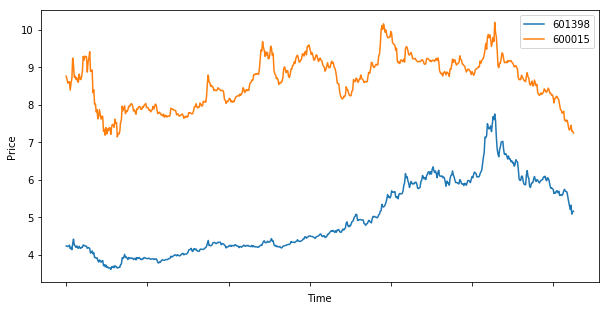

In [11]:
##从选出的股票里挑选p值最低的，也就是我们认为最符合协整关系的来看看他们之间的股价走势是怎么样的.
stock_sample1 = df['601398']
stock_sample2 = df['600015']
stock_sample1.plot(figsize=(10,5));
stock_sample2.plot(figsize=(10,5));
plt.xlabel("Time"); 
plt.ylabel("Price");
plt.legend(['601398', '600015']);

In [12]:
##要利用这组股票对进行配对交易，就得看看他们之间的存在什么样的线性关系。
##这里我们通过股价进行最小残差平方和（OLS）方法来进行回归。
x = stock_sample1
y = stock_sample2
X = sm.add_constant(x)
result = (sm.OLS(y,X)).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 600015   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     288.3
Date:                Wed, 04 Jul 2018   Prob (F-statistic):           1.91e-53
Time:                        16:13:51   Log-Likelihood:                -500.48
No. Observations:                 626   AIC:                             1005.
Df Residuals:                     624   BIC:                             1014.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7658      0.112     60.647      0.0

2.9100456025512895


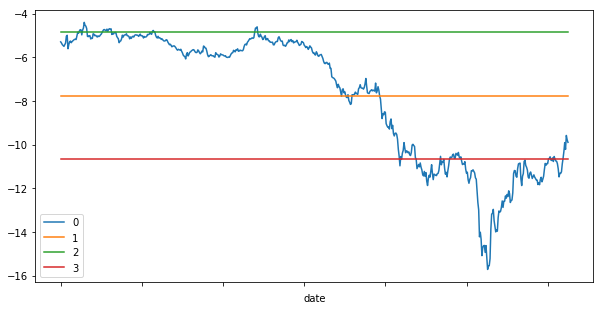

In [13]:
##接下来我们看看线性组合的价差是否是在均值周围波动。
##
diff=y-3.3207*x
mean=np.mean(diff)
std=np.std(diff)
print(std)
up=mean+std
down=mean-std
time=diff.index
mean_line=pd.Series(mean,index=time)
up_line=pd.Series(up,index=time)
down_line=pd.Series(down,index=time)
set=pd.concat([diff,mean_line,up_line,down_line],axis=1)
set.plot(figsize=(10,5))